### Analysis of 2024 (first semester available in the official website of data.gouv.fr)

We import the file, then we check by 'chunk' (to not work too much the machine) the first lines in purpose to ensure validity

In [1]:
import pandas as pd

# path of the file (adjust it according to your computer)
file_path = 'C:/Users/NEZHA/OneDrive/Documents/DVF/ValeursFoncieres-2024-S1.txt'

# Columns that we conserve to our little check, we will display their first lines 
cols_to_keep = ['Date mutation', 'Valeur fonciere', 'Code postal', 'Commune', 
                'Surface Carrez du 1er lot', 'Nombre de lots', 'Type local', 'Surface reelle bati']

# 100 000 lines at a time
chunksize = 100000
chunks = pd.read_csv(file_path, delimiter='|', encoding='utf-8', chunksize=chunksize, usecols=cols_to_keep, low_memory=False)

# We display five lines to check if the importation is valid
for chunk in chunks:
    print(chunk.head())
    break  # We stop after the first chunk... that's enough

  Date mutation Valeur fonciere  Code postal Commune  \
0    02/01/2024          346,50       1230.0  CHALEY   
1    03/01/2024        10000,00       1170.0  CHEVRY   
2    08/01/2024       249000,00       1290.0    LAIZ   
3    03/01/2024       329500,00       1170.0     GEX   
4    03/01/2024       329500,00       1170.0     GEX   

  Surface Carrez du 1er lot  Nombre de lots  Type local  Surface reelle bati  
0                       NaN               0         NaN                  NaN  
1                       NaN               0         NaN                  NaN  
2                       NaN               0         NaN                  NaN  
3                       NaN               2  Dépendance                  0.0  
4                       NaN               2  Dépendance                  0.0  


it works perfectly ! let's keep going... Now we filter and keep the data which corresponds to the postal codes for the center of Paris metropolitan area (we consider that the center is Paris intra-muros), and we check the first lines...

In [2]:
import pandas as pd  # we re-import to be sure it works well ('cause sometimes it doesn't works)
file_path = 'C:/Users/NEZHA/OneDrive/Documents/DVF/ValeursFoncieres-2024-S1.txt'

# We load the CSV file into a Pandas DataFrame with a custom delimiter ('|'), then we specify the UTF-8 encoding to avoid character issues, and we disbale memory optimization to ensure correct loading of data types (even if its not that bad to let it)
df = pd.read_csv(file_path, delimiter='|', encoding='utf-8', low_memory=False)

# Filtering for center of Paris's agglomeration, Paris intra-muros (postal codes between 75000 and 75020)
df_paris = df[df['Code postal'].between(75000, 75020)].copy()

pd.set_option('display.max_columns', None) # we display all columns 

# little sample to check on
df_paris_sample = df_paris.head()  # five lines

# we display the sample
print(df_paris_sample)

         Identifiant de document  Reference document  1 Articles CGI  \
1442424                      NaN                 NaN             NaN   
1442425                      NaN                 NaN             NaN   
1443191                      NaN                 NaN             NaN   
1443192                      NaN                 NaN             NaN   
1443370                      NaN                 NaN             NaN   

         2 Articles CGI  3 Articles CGI  4 Articles CGI  5 Articles CGI  \
1442424             NaN             NaN             NaN             NaN   
1442425             NaN             NaN             NaN             NaN   
1443191             NaN             NaN             NaN             NaN   
1443192             NaN             NaN             NaN             NaN   
1443370             NaN             NaN             NaN             NaN   

         No disposition Date mutation Nature mutation Valeur fonciere  \
1442424               1    05/01/2024      

Now, we extract years of the dates to create a new column, initially we wanted to treat all files in one so it could be useful, however the files must be treat differently because of the quality of our computer, it crashs every time. So it is useless to do it, but at least to show our main idea.

In [3]:
# we convert the column 'Date mutation' of the dataFrame in the format 'date'
df_paris['Date mutation'] = pd.to_datetime(df_paris['Date mutation'], errors='coerce')

# we check 
print(df_paris[['Date mutation']].head())

# Then we extract
df_paris['Année'] = df_paris['Date mutation'].dt.year

# we check/display the results
print(df_paris[['Date mutation', 'Année']].head())


        Date mutation
1442424    2024-05-01
1442425    2024-05-01
1443191           NaT
1443192           NaT
1443370           NaT
        Date mutation   Année
1442424    2024-05-01  2024.0
1442425    2024-05-01  2024.0
1443191           NaT     NaN
1443192           NaT     NaN
1443370           NaT     NaN


In [4]:
# We create a copy of df_paris to avoid the view and work directly on the copy
df_paris_copy = df_paris.copy()

# We replace commas by points in the column 'Valeur fonciere' of the dataFrame
df_paris_copy['Valeur fonciere'] = df_paris_copy['Valeur fonciere'].replace({',': '.'}, regex=True)

# We convert 'Valeur fonciere' column to numeric, forcing errors to NaN
df_paris_copy['Valeur fonciere'] = pd.to_numeric(df_paris_copy['Valeur fonciere'], errors='coerce')

# we verify the type to check if it worked
print(df_paris_copy['Valeur fonciere'].dtype)  # it must display 'float64'

# We check the first lines
print(df_paris_copy[['Valeur fonciere']].head())


float64
         Valeur fonciere
1442424         562400.0
1442425         562400.0
1443191         580000.0
1443192         580000.0
1443370         880000.0


Little manipulation to see the some outliers

In [12]:
# Filtrer les transactions dont la valeur foncière est plus élevée que 1 million
high_value_transactions = df_paris_copy[df_paris_copy['Valeur fonciere'] > 1000000]

# Afficher les premières lignes des transactions avec des valeurs élevées
print(high_value_transactions[['Valeur fonciere']].head())

         Valeur fonciere
1446406        1285000.0
1446407        1285000.0
1446408        1285000.0
1530093        1042000.0
1530094        1042000.0


We will not do the same to show outliers 'cause that of 2019 was enough to understand the problem, so lets get into the matter directly

In [14]:
# We check if the 'surface réelle bati' is present and valid
df_paris_copy['Prix_m2'] = df_paris_copy['Valeur fonciere'] / df_paris_copy['Surface reelle bati']

# We filter for values of price per m² reasonable, we don't use quantiles because otherwise ou computer bugs, but it would be the best idea... 
df_paris_filtered_m2 = df_paris_copy[df_paris_copy['Prix_m2'] < 30000]  # seuil de 30000

# After filtering, we calcul again
prix_moyen_par_annee_m2 = df_paris_filtered_m2.groupby('Année')['Prix_m2'].mean()

# We display
print(prix_moyen_par_annee_m2)

Année
2024.0    9962.475912
Name: Prix_m2, dtype: float64


to make you aware of the evolution between solely 2 point, here is a graphic !

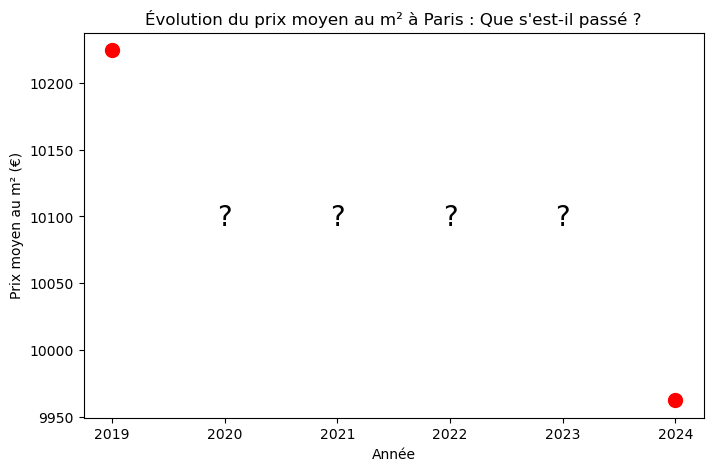

In [16]:
import matplotlib.pyplot as plt

# prices/m² of 2019 and 2024 
annees = [2019, 2024]
prix_m2 = [10224.400024, 9962.475912]

# We creat the graphic
plt.figure(figsize=(8, 5))
plt.scatter(annees, prix_m2, color='red', s=100, label="Prix moyen")

# We add question marks to keep the surprise...
annees_mystere = [2020, 2021, 2022, 2023]
prix_mystere = [None] * len(annees_mystere)  # so empty values
for an in annees_mystere:
    plt.text(an, (max(prix_m2) + min(prix_m2)) / 2, "?", fontsize=20, ha='center', color='black')

# labels + title
plt.xlabel("Année")
plt.ylabel("Prix moyen au m² (€)")
plt.title("Évolution du prix moyen au m² à Paris : Que s'est-il passé ?")

# we define the scale for X
plt.xticks(annees + annees_mystere)

# let's display
plt.show()
